In [1]:
import glob
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

from sklearn.utils import resample
from keras.models import Sequential
from keras.layers import Dense, SeparableConv2D, Conv2D, MaxPooling2D,GlobalAveragePooling2D,MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping # prevent overfitting
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import auc, roc_curve
from keras.regularizers import l2
from keras.applications.vgg19 import VGG19
from keras.applications.densenet import DenseNet121
from keras.models import Model
import tensorflow as tf
#from imblearn.over_sampling import SMOTE



%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
#pip install opencv-python
#pip install tensorflow
#pip install Keras
#pip install imblearn

# 1. Data Preparation

## 1.1 Loading data from directories

In [3]:
# main path
path = 'data/chest_xray/'

# define paths
train_normal_dir = path + 'train/NORMAL/'
train_pneu_dir = path + 'train/PNEUMONIA/'

test_normal_dir = path + 'test/NORMAL/'
test_pneu_dir = path + 'test/PNEUMONIA/'

val_normal_dir = path + 'val/NORMAL/'
val_pneu_dir = path + 'val/PNEUMONIA/'


# look for all the jpeg files 
train_normal_cases = glob.glob(train_normal_dir + '*jpeg')
train_pneu_cases = glob.glob(train_pneu_dir + '*jpeg')

test_normal_cases = glob.glob(test_normal_dir + '*jpeg')
test_pneu_cases = glob.glob(test_pneu_dir + '*jpeg')

val_normal_cases = glob.glob(val_normal_dir + '*jpeg')
val_pneu_cases = glob.glob(val_pneu_dir + '*jpeg')


# create a new path
train_normal_cases = [x.replace('\\', '/') for x in train_normal_cases]
train_pneu_cases = [x.replace('\\', '/') for x in train_pneu_cases]
test_normal_cases = [x.replace('\\', '/') for x in test_normal_cases]
test_pneu_cases = [x.replace('\\', '/') for x in test_pneu_cases]
val_normal_cases = [x.replace('\\', '/') for x in val_normal_cases]
val_pneu_cases = [x.replace('\\', '/') for x in val_pneu_cases]


# create lists for train, test & validation cases, create labels as well
train_list = []
test_list = []
val_list = []

# 0 is normal and 1 is pneumonia 
for x in train_normal_cases:
    train_list.append([x, 0])
    
for x in train_pneu_cases:
    train_list.append([x, 1])
    
for x in test_normal_cases:
    test_list.append([x, 0])
    
for x in test_pneu_cases:
    test_list.append([x, 1])
    
for x in val_normal_cases:
    val_list.append([x, 0])
    
for x in val_pneu_cases:
    val_list.append([x, 1])


# shuffle all sets 
rn.shuffle(train_list)
rn.shuffle(test_list)
rn.shuffle(val_list)


# create dataframes
train_df = pd.DataFrame(train_list, columns=['image', 'class'])
test_df = pd.DataFrame(test_list, columns=['image', 'class'])
val_df = pd.DataFrame(val_list, columns=['image', 'class'])

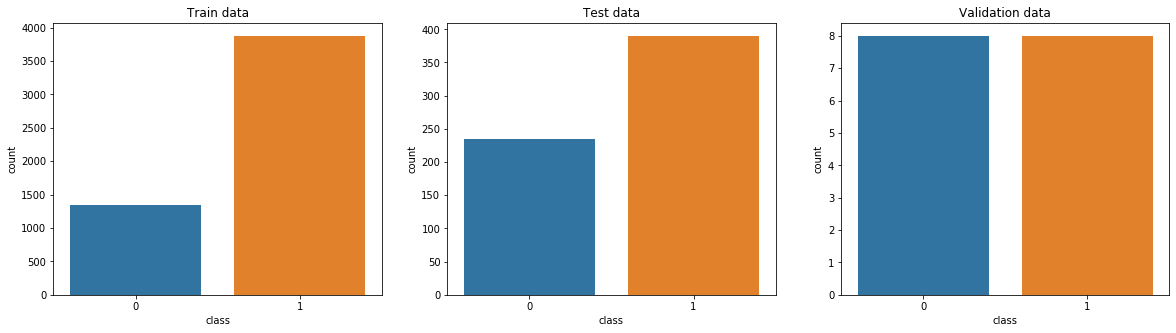

In [4]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.countplot(train_df['class'])
plt.title('Train data')

plt.subplot(1,3,2)
sns.countplot(test_df['class'])
plt.title('Test data')

plt.subplot(1,3,3)
sns.countplot(val_df['class'])
plt.title('Validation data')

plt.show()

* There are only 16 images in the validation set. 

## 1.2 Re-sampling training and validation sets 

In [5]:
# Split train_df and val_df into a 90:10 ratio 
comb_df = pd.concat([train_df,val_df])
train_df_, val_df_ = train_test_split(comb_df, test_size = 0.1)

In [6]:
# Define function that oversamples the normal class 
def balance(df):
    major = df[df['class'] == 1]
    minor = df[df['class'] == 0]
    minor_oversampled  = resample(minor,
                                 replace = True,
                                 n_samples = round(major['class'].value_counts()[1]),
                                 random_state = 42)
    combined_df = pd.concat([major, minor_oversampled])
    return combined_df

In [7]:
train_df = balance(train_df_)
val_df = balance(val_df_)
train_df = train_df.sample(frac = 1)
val_df = val_df.sample(frac = 1)

* Here is the result after re-balancing the dataset.

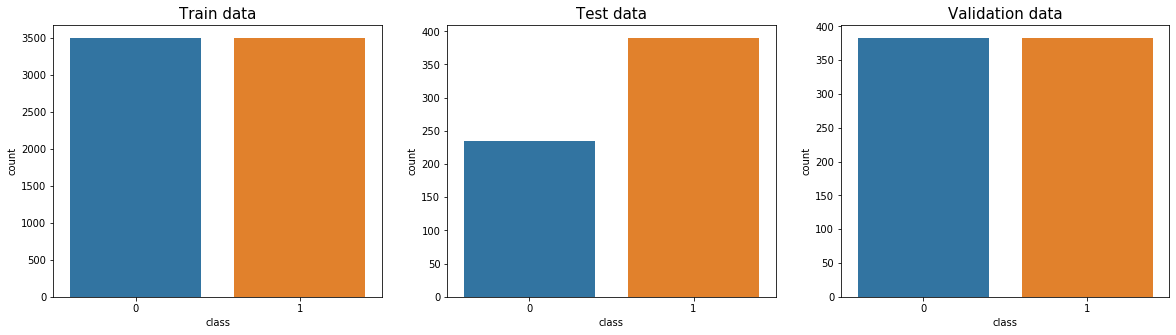

In [8]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.countplot(train_df['class'])
plt.title('Train data',fontsize=15)

plt.subplot(1,3,2)
sns.countplot(test_df['class'])
plt.title('Test data',fontsize=15)

plt.subplot(1,3,3)
sns.countplot(val_df['class'])
plt.title('Validation data',fontsize=15)

plt.show()
#plt.savefig('graph/dataset-overview-.jpeg')

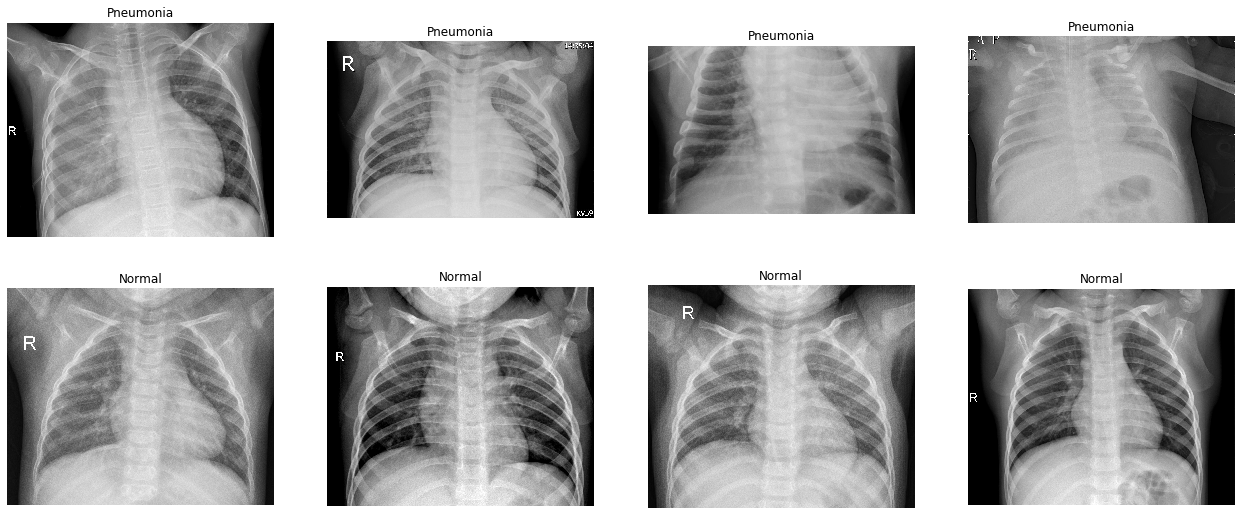

In [9]:
plt.figure(figsize=(22,9))

# plot 1st row for pneumonia xrays
for i,img_path in enumerate(train_df[train_df['class'] == 1][0:4]['image']):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Pneumonia')

# plot 2nd row for pneumonia xrays    
for i,img_path in enumerate(train_df[train_df['class'] == 0][0:4]['image']):
    plt.subplot(2,4,4+i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Normal')

#plt.savefig('graph/pneumonia-normal-example')

In [10]:
# pre-process & normalize image
def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (320, 320))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (320,320,1))
    return img

# write a function to separate features and labels.
def compose_dataset(df):
    img = []
    labels = []

    for img_path, label in df.values:
        img.append(process_data(img_path))
        labels.append(label)
        
    return np.array(img), np.array(labels)

In [11]:
X_train, y_train = compose_dataset(train_df)
X_test, y_test = compose_dataset(test_df)
X_val, y_val = compose_dataset(val_df)

print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

Train data shape: (7000, 320, 320, 1), Labels shape: (7000,)
Test data shape: (624, 320, 320, 1), Labels shape: (624,)
Validation data shape: (766, 320, 320, 1), Labels shape: (766,)


## 1.3 Image Augmentation

In [12]:
# define generator for traing data 
image_gen = ImageDataGenerator(
            #samplewise_center = True, #set each sample mean to 0 
            #samplewise_std_normalization = True, # divide each input by its std to normalize 
            #rescale = 1./255,
            rotation_range = 20, # randomly rotate image from -30 degree to 30 degree
            width_shift_range = 0.1, #randomly shift images horizontally
            height_shift_range = 0.1, #randomly shift images vertically
            shear_range = 0.2, #randomly change shear intensity
            zoom_range = 0.2, # random zoom images
            horizontal_flip = False, # randomly flip images
            vertical_flip = False
)

# fit generator on our train features
image_gen.fit(X_train)

# 2. Model

## 2.1 Define Keras model

In [13]:
model = Sequential()

# first conv layer
model.add(Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu'))#, kernel_regularizer = l2( l= 0.01)))
model.add(Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_regularizer = l2(l = 0.01)))
#model.add(BatchNormalization()) #keep the mean outout close to 0 and output std close to 1
model.add(MaxPool2D(pool_size = (2,2)))

# second conv layer
model.add(SeparableConv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'))#kernel_regularizer = l2(l = 0.01)))
model.add(SeparableConv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_regularizer = l2(l = 0.001)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.1))

# third conv layer 
model.add(SeparableConv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu'))# kernel_regularizer = l2(l = 0.01)))
model.add(SeparableConv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_regularizer = l2(l = 0.001)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.1))

# forth conv layer
model.add(SeparableConv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))#, kernel_regularizer = l2(l = 0.01)))
model.add(SeparableConv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_regularizer = l2(l = 0.001)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.2))

# fifth conv layer
model.add(SeparableConv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))#, kernel_regularizer = l2(l = 0.01)))
model.add(SeparableConv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_regularizer = l2(l = 0.001)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.2))

# fully connected layer
model.add(Flatten())
model.add(Dense(units = 1024, activation = 'relu', kernel_regularizer = l2(l = 0.001)))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.5)) # remove input to a layer (may also be input to the previous layer) to reduce overfitting issues 
#model.add(BatchNormalization())
#model.add(Dense(units = 128, activation = 'relu')) #, kernel_regularizer = l2(l = 0.01)))
#model.add(Dropout(rate = 0.5))
#model.add(BatchNormalization())
model.add(Dense(units = 512, activation = 'relu', kernel_regularizer = l2(l = 0.001)))
model.add(Dropout(rate = 0.3))

# output layer
model.add(Dense(units = 1, activation = 'sigmoid')) 

# compile a sequential model
optimizer = Adam(0.001)
model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

## 2.2 Weight adjustment (not applicable)

In [14]:
# define path
train = "data/chest_xray/train"
test = "data/chest_xray/test"
val = "data/chest_xray/val"

# Number of negative and positive cases 
num_pneumonia = len(os.listdir(os.path.join(train, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train, 'NORMAL')))
num_total = num_pneumonia + num_normal

# Modify class weights
weight_pneumonia = num_pneumonia/ num_total
weight_normal = num_normal/num_total
modified_weight = {0: weight_pneumonia, 1: weight_normal}
modified_weight_ = {0: 4.5, 1:1}

In [15]:
modified_weight

{0: 0.7429064417177914, 1: 0.2570935582822086}

## 2.3 Model training

In [16]:
# Calculate parameters
batch_size = 32
steps_per_epoch = train_df.shape[0] // batch_size
validation_steps = val_df.shape[0] // batch_size


In [17]:
# Callbacks

# save the weights of the best model 
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)

# reduce the learning rate when val_loss is getting large. 
lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.3, patience=5, verbose=2, mode='max',min_lr=0.00001)

# set early stopping monitor so the model stops training when it won't improve anymore
early_stop = EarlyStopping(monitor='val_loss', min_delta = 0, patience = 2, mode='min')


In [18]:
hist = model.fit_generator(image_gen.flow(X_train, y_train, batch_size = batch_size), #train set 
                 validation_data = (X_val, y_val), 
                 epochs = 15,
                 steps_per_epoch = steps_per_epoch,
                 verbose =1,
                 callbacks = [lr]) 
                 #class_weight= modified_weight_,
                 #validation_steps = 25)

Epoch 1/15
218/218 [==============================] - 126s 555ms/step - loss: 1.8030 - accuracy: 0.8482 - val_loss: 1.6102 - val_accuracy: 0.5000
Epoch 2/15
218/218 [==============================] - 118s 540ms/step - loss: 0.9521 - accuracy: 0.8966 - val_loss: 4.2577 - val_accuracy: 0.5000
Epoch 3/15
218/218 [==============================] - 118s 541ms/step - loss: 0.5635 - accuracy: 0.9190 - val_loss: 2.9281 - val_accuracy: 0.5000
Epoch 4/15
218/218 [==============================] - 118s 540ms/step - loss: 0.4573 - accuracy: 0.9182 - val_loss: 0.4789 - val_accuracy: 0.8982
Epoch 5/15
218/218 [==============================] - 118s 540ms/step - loss: 0.4039 - accuracy: 0.9292 - val_loss: 1.6986 - val_accuracy: 0.5078
Epoch 6/15
218/218 [==============================] - 118s 540ms/step - loss: 0.4044 - accuracy: 0.9240 - val_loss: 0.3616 - val_accuracy: 0.9256
Epoch 7/15
218/218 [==============================] - 118s 539ms/step - loss: 0.3685 - accuracy: 0.9319 - val_loss: 2.1401 -

# 3. Results & Evaluations

## 3.1 Accuracy vs Loss Plot 

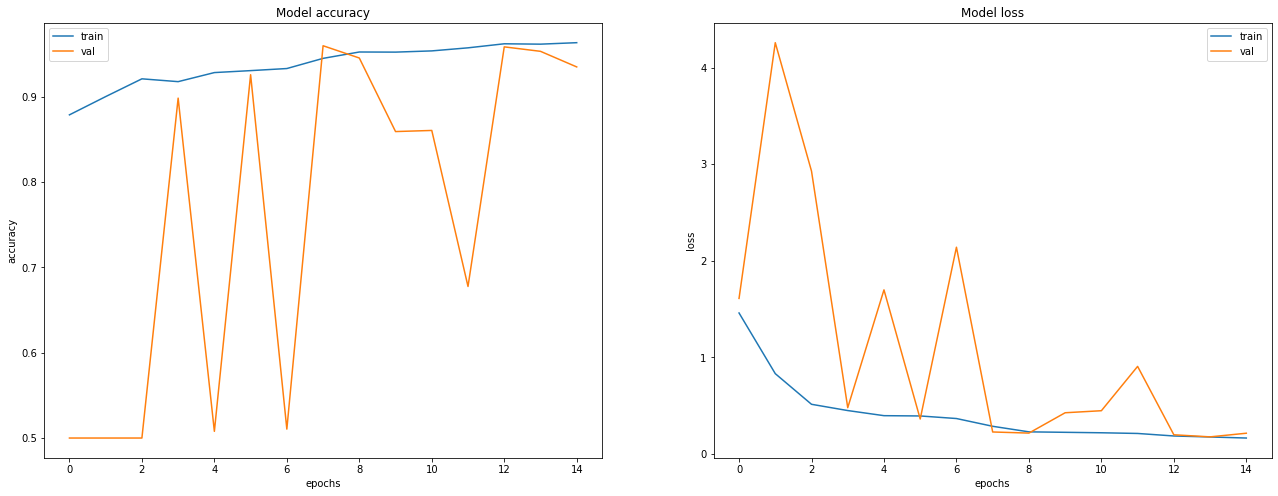

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(22, 8))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
#plt.savefig('bad-acc-loss.jpeg')

In [20]:
# print out the accuracy score
test_accuracy = model.evaluate(X_test, y_test)
print('The testing accuracy is :',test_accuracy[1]*100, '%')

20/20 [==============================] - 3s 129ms/step - loss: 0.3562 - accuracy: 0.8894
The testing accuracy is : 88.94230723381042 %


## 3.2 ROC Curve & Confusion Matrix

### ROC Curve

* A ROC curve was plotted to determine the optimal threshold for the confusion matrix

In [21]:
# predict probabilities
y_pred_proba = model.predict_proba(X_test)

# compute false positive and true positive rate 
fpr, tpr, thres = roc_curve(y_test, y_pred_proba)

# area under curve 
auc_keras = auc(fpr, tpr)

# Calculate gmeans
gmeans = np.sqrt(tpr * (1-fpr))

# Get the best threshold
ix = np.argmax(gmeans)
best_thres = thres[ix]
print('Best Threshold = {}'.format(best_thres))

Best Threshold = 0.39110067486763


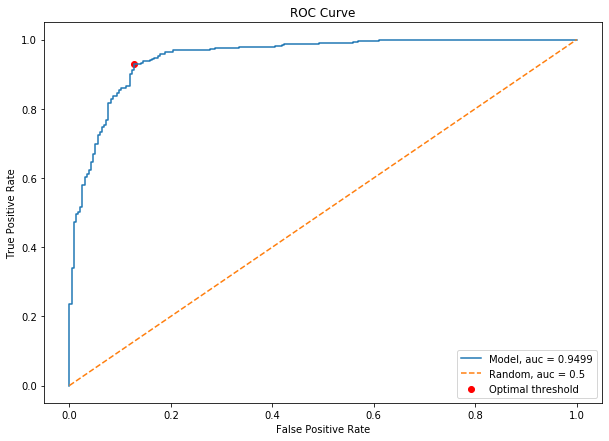

In [22]:
# Plotting ROC curve 

plt.subplots(figsize = (10,7))
plt.plot(fpr,tpr,label = model)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.scatter(fpr[ix], tpr[ix], marker = 'o', color = 'red', label = 'Best threshold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(labels = ['Model, auc = {:.4f}'.format(auc_keras), 'Random, auc = 0.5', 'Optimal threshold'])
#plt.savefig('graph/base-roc.png')

### Confusion Matrix

In [27]:
y_pred = model.predict_classes(X_test, batch_size=32)
cm = confusion_matrix(y_test, y_pred > 0.39110067486763)
print(cm)

[[206  28]
 [ 41 349]]


In [36]:
y_pred_ = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_ > 0.2)

In [37]:
cm

array([[192,  42],
       [ 16, 374]])

Text(0.5, 1, 'Confusion Matrix of Base Model')

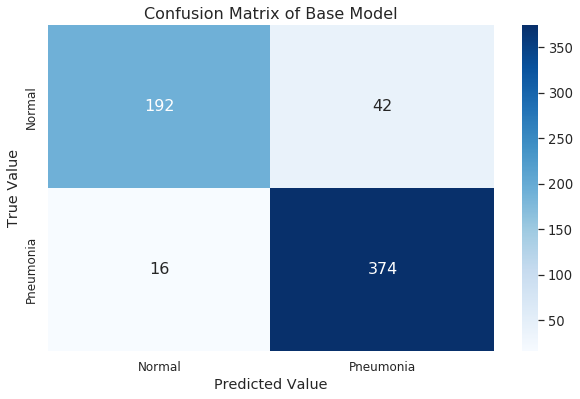

In [38]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt = "g",cmap = "Blues",annot_kws={"size": 16})
sns.set(font_scale=1.2) # for label size
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
ax.set_xticklabels(['Normal','Pneumonia'], fontsize = 12)
ax.set_yticklabels(['Normal','Pneumonia'], va='center', rotation = 90, position=(0,0.28),fontsize = 12)
plt.title('Confusion Matrix of Base Model' , fontsize = 16)
#plt.savefig('graph/base-confusion-matrix-base.png')

### Classfication Report

In [39]:
classification_rep = classification_report(y_test, y_pred)
classification_report
print(classification_rep)

              precision    recall  f1-score   support

           0       0.83      0.88      0.86       234
           1       0.93      0.89      0.91       390

    accuracy                           0.89       624
   macro avg       0.88      0.89      0.88       624
weighted avg       0.89      0.89      0.89       624



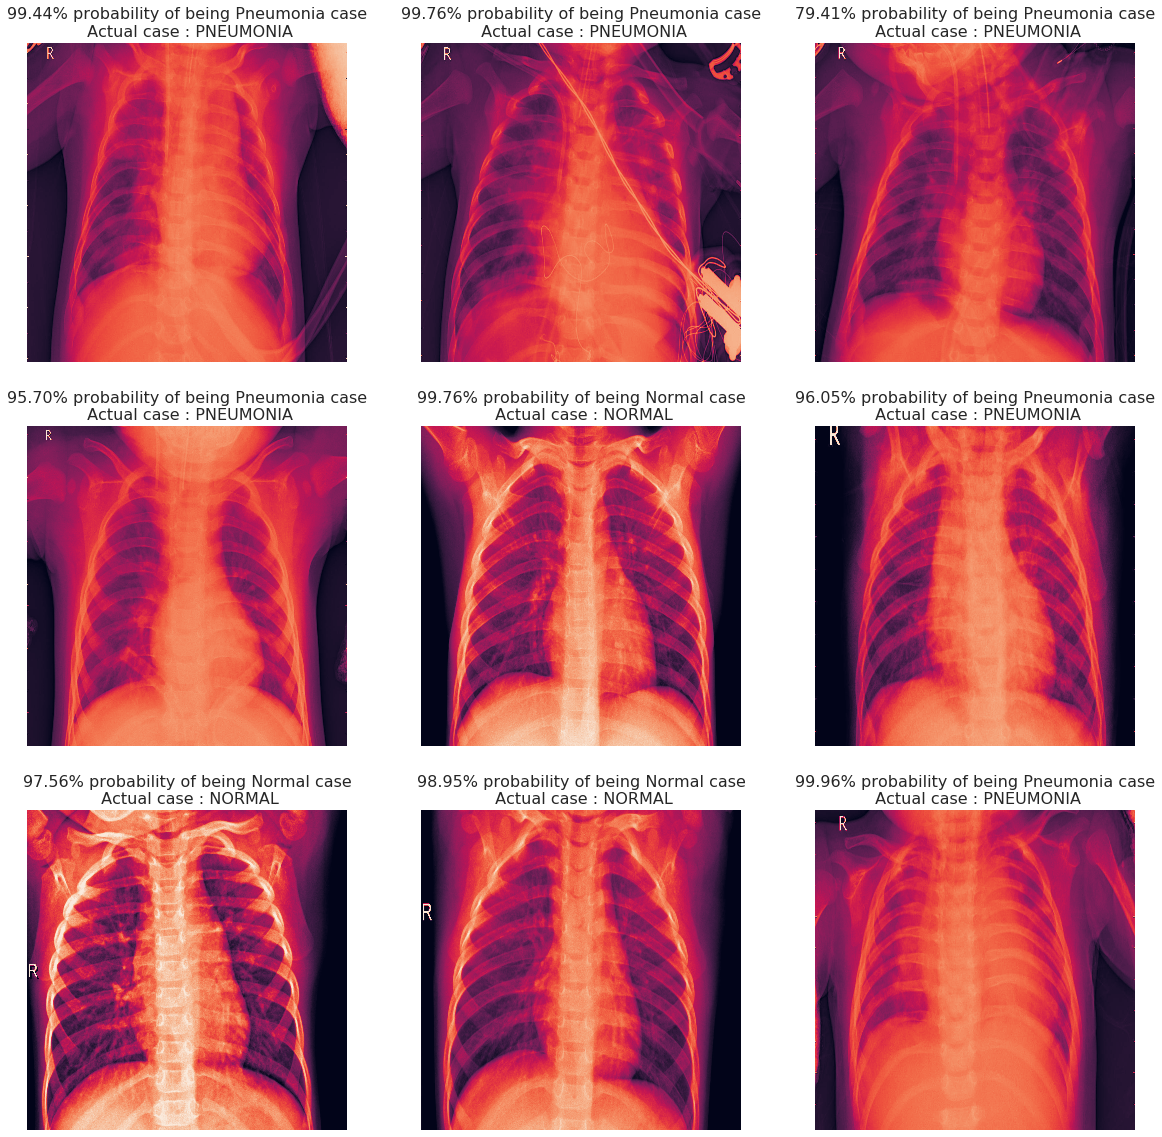

In [42]:
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+25, 9+25):
    plt.subplot(3, 3, (i-25)+1)
    if y_pred[i] >= 0.5: 
        out = ('{:.2%} probability of being Pneumonia case'.format(y_pred_proba[i][0]))
         
    else: 
        out = ('{:.2%} probability of being Normal case'.format(1-y_pred_proba[i][0]))
      
      

    plt.title(out + "\n Actual case : "+ dic.get(y_test[i]), fontsize = 16)    
    plt.imshow(np.squeeze(X_test[i]))
    plt.axis('off')
#plt.savefig('graph/prediction-base-model.png')

In [43]:
from sklearn.metrics import precision_recall_curve

Best Threshold=0.162077, F-Score=0.928


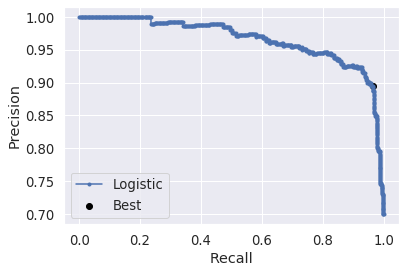

In [45]:
# Precision - Recall
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
#no_skill = len(testy[testy==1]) / len(testy)
#pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
#pyplot.show()

In [46]:
y_pred_prec_rec = model.predict(X_test)
cm_prec_rec = confusion_matrix(y_test, y_pred_prec_rec > 0.162077)

In [47]:
cm_prec_rec

array([[190,  44],
       [ 14, 376]])

## Testing model with real life data

In [ ]:
sample_path = 'sample-xray'

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
# preprocess sample imgage
covid_img = image.load_img(sample_path, color_mode = 'grayscale', target_size = (320,320))
covid_img = image.img_to_array(covid_img)
covid_img = covid_img/255
covid_img = np.expand_dims(covid_img, axis=0)

plt.imshow(np.squeeze(covid_img))

In [ ]:
covid_img.shape

In [ ]:
#predict 
covid_pred = model.predict(covid_img)

In [ ]:
plt.figure(figsize=(6,6))
plt.axis('off')
if covid_pred>= 0.5: 
    out = ('I am {:.2%} percent confirmed that this is a Pneumonia case'.format(covid_pred[0][0]))
    
else: 
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(1-covid_pred[0][0]))
plt.title("Covid-19 Pneumonia X-ray \n"+out)  
plt.imshow(np.squeeze(covid_img))
plt.show()

In [ ]:
sample_path_ = 'covid-19-pneumonia-tube'
# preprocess sample imgage
covid_img_tube = image.load_img(sample_path_, color_mode = 'grayscale', target_size = (320,320))
covid_img_tube = image.img_to_array(covid_img_tube)
covid_img_tube = covid_img_tube/255
covid_img_tube = np.expand_dims(covid_img_tube, axis=0)

#plt.imshow(np.squeeze(covid_img_tube))

In [ ]:
#predict 
covid_pred_ = model.predict(covid_img_tube)

plt.figure(figsize=(6,6))
plt.axis('off')
if covid_pred>= 0.5: 
    out = ('I am {:.2%} percent confirmed that this is a Pneumonia case'.format(covid_pred_[0][0]))
    
else: 
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(1-covid_pred_[0][0]))
plt.title("Covid-19 Pneumonia X-ray \n"+out)  
plt.imshow(np.squeeze(covid_img_tube))
plt.show()

### Save model

In [ ]:
# Save model 
# serialize to JSON
json_file = model.to_json()
with open('bad-model.json', "w") as file:
    file.write(json_file)
# serialize weights to HDF5
model.save_weights('bad_weight.h5')

json_file = model.to_json()
with open('base-line-model.json', "w") as file:
    file.write(json_file)
#serialize weights to HDF5
model.save_weights('baseline_model_weight.h5')